In [216]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from numpy import zeros_like
from IPython.display import display
def display_matrix(m):
    display(sympy.Matrix(m))
import sympy
import pandas as pd
import scipy.stats as ss

sympy.init_printing()

# Processer

In [217]:
def merton_jump_paths(S0, paths, lam, sigma, mu, v, m, T, I):
    np.random.seed(42)
    matrix = np.zeros((paths, I))
    for k in range(paths):
        X = np.zeros(I)
        S = np.zeros(I)
        
        S[0] = S0
        X[0] = np.log(S0)
        
        dt = T / I
    
        for i in range(1,I):
            Z = np.random.standard_normal()
            N = np.random.poisson(lam * dt)
            Y = np.exp(np.random.normal(m,v,N))
            #Y = np.random.lognormal(m,np.sqrt(v),N)
    
            if N == 0:
                M = 0
            else:
                M = np.sum(np.log(Y))
                
            X[i] = X[i-1] + (mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z + M
            S[i] = np.exp(X[i])
        matrix[k] = S
    return matrix


# drop model

def merton_jump_to_ruin_paths(S0, paths, lam, sigma, mu, v, m, T, I):
    np.random.seed(42)
    matrix = np.zeros((paths, I))
    for k in range(paths):
        X = np.zeros(I)
        S = np.zeros(I)

        X[0] = np.log(S0)
        S[0] = S0
        dt = T / I
    
        for i in range(1,I):
            Z = np.random.standard_normal()
            N = np.random.poisson(lam * dt)
            #Y = np.exp(np.random.normal(m,v,N))
    
            if N == 0 and X[i-1] > 0:
                X[i] = X[i-1] + (mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z
                S[i] = np.exp(X[i])
            else:
                S[i] = 0
        matrix[k] = S
    return matrix

In [218]:
#def merton_jump_paths(S0, paths, lam, sigma, mu, v, m, T, I):
#    np.random.seed(42)
#    matrix = np.zeros((paths, I))
#    for k in range(paths):
#        X = np.zeros(I)
#        S = np.zeros(I)
#        
#        S[0] = S0
#        X[0] = np.log(S0)
#        
#        dt = T / I
#    
#        for i in range(1,I):
#            Z = np.random.standard_normal()
#            Z2 = np.random.standard_normal()
#            N = np.random.poisson(lam * dt)
#
#            if N == 0:
#                M = 0
#            else:
#                M = m * N + np.sqrt(v) * np.sqrt(N) * Z2
#                
#            X[i] = X[i-1] + (mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z + M
#            S[i] = np.exp(X[i])
#        matrix[k] = S
#    return matrix
#

In [219]:
def merton_jump_paths1(S0, paths, lam, sigma, mu, v, m, T, I):
    size=(I,paths)
    dt = T/I 
    poi_rv = np.multiply(np.random.poisson( lam*dt, size=size), np.random.normal(m,v, size=size)).cumsum(axis=0)
    geo = np.cumsum(((mu -  sigma**2/2 -lam*(m  + v**2*0.5))*dt + sigma*np.sqrt(dt) * np.random.normal(size=size)), axis=0)
    return np.exp(geo+poi_rv)*S0

def merton_jump_to_ruin_paths1(S0, paths, lam, sigma, mu, v, m, T, I):
    size = (I, paths)
    dt = T/I
    jump_indices = np.random.poisson(lam*dt, size=size)
    ruin_indices = np.cumsum(jump_indices, axis=0) > 0  # Identify points after the jump

    # Geometric Brownian Motion component
    geo = np.cumsum((mu - sigma**2/2)*dt + sigma*np.sqrt(dt) * np.random.normal(size=size), axis=0)

    # Combine and apply the ruin effect
    stock_paths = np.exp(geo)*S0
    stock_paths[ruin_indices] = 0  # Set to zero after the jump
    return stock_paths

# LSM

In [1]:
import numpy as np

def LSM(K, S, I, df, basis, deg):
    paths = len(S)
    H = np.maximum(K - S, 0)  # intrinsic values for put option
    V = np.zeros_like(H)  # value matrix
    V[:, -1] = H[:, -1]  # set value at maturity equal to intrinsic value

    # Valuation by LS Method
    for t in range(I - 2, 0, -1):
        good_paths = H[:, t] > 0  # paths where the intrinsic value is positive

        if np.sum(good_paths) > 0:
            if basis == 'poly':
                rg = np.polyfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polyval(rg, S[good_paths, t])
            elif basis == 'legendre':
                rg = np.polynomial.legendre.legfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.legendre.legval(S[good_paths, t], rg)
            elif basis =='laguerre':
                rg = np.polynomial.laguerre.lagfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.laguerre.lagval(S[good_paths, t], rg)
            else:  # 'hermite'
                rg = np.polynomial.hermite.hermfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.hermite.hermval(S[good_paths, t], rg)

            exercise = np.zeros(len(good_paths), dtype=bool)
            exercise[good_paths] = H[good_paths, t] > C
        else:
            # If all intrinsic values are zero, mark all as non-exercise
            exercise = np.zeros(len(good_paths), dtype=bool)

        V[exercise, t] = H[exercise, t]
        V[exercise, t + 1 :] = 0
        discount_path = ~exercise
        V[discount_path, t] = V[discount_path, t + 1] * df
    
    V0 = np.mean(V[:, 1]) * df  # discounted expectation of V[t=1]
    V0_array = V[:, 1] * df
    SE = np.std(V[:, 1] * df) / np.sqrt(paths)
    return V0, V0_array, SE

In [221]:
def merton_jump_paths1(S0, paths, lam, sigma, mu, v, m, T, I):
    size=(I,paths)
    dt = T/I 
    poi_rv = np.multiply(np.random.poisson( lam*dt, size=size), np.random.normal(m,v, size=size)).cumsum(axis=0)
    geo = np.cumsum(((mu -  sigma**2/2 -lam*(m  + v**2*0.5))*dt + sigma*np.sqrt(dt) * np.random.normal(size=size)), axis=0)
    return np.exp(geo+poi_rv)*S0

def merton_jump_to_ruin_paths1(S0, paths, lam, sigma, mu, v, m, T, I):
    size = (I, paths)
    dt = T/I
    jump_indices = np.random.poisson(lam*dt, size=size)
    ruin_indices = np.cumsum(jump_indices, axis=0) > 0  # Identify points after the jump

    # Geometric Brownian Motion component
    geo = np.cumsum((mu - sigma**2/2)*dt + sigma*np.sqrt(dt) * np.random.normal(size=size), axis=0)

    # Combine and apply the ruin effect
    stock_paths = np.exp(geo)*S0
    stock_paths[ruin_indices] = 0  # Set to zero after the jump
    return stock_paths

In [222]:
deg = 3
basis = 'legendre'
#initial price list
S0 = 40
K = 40

In [223]:
mu = 0.06
r = 0.06
T = 1
I = 50
paths = 10000
m = 0

GBM_lam = 0
GBM_sigma = 0.04
GBM_mu = r
GBM_v = 0

LN_lam = 1
LN_sigma = 0.02
LN_mu = r
LN_v = 0.02

JR_lam = 0.01
JR_sigma = 0.03
JR_mu = r + JR_lam

df = np.exp(-mu*T)

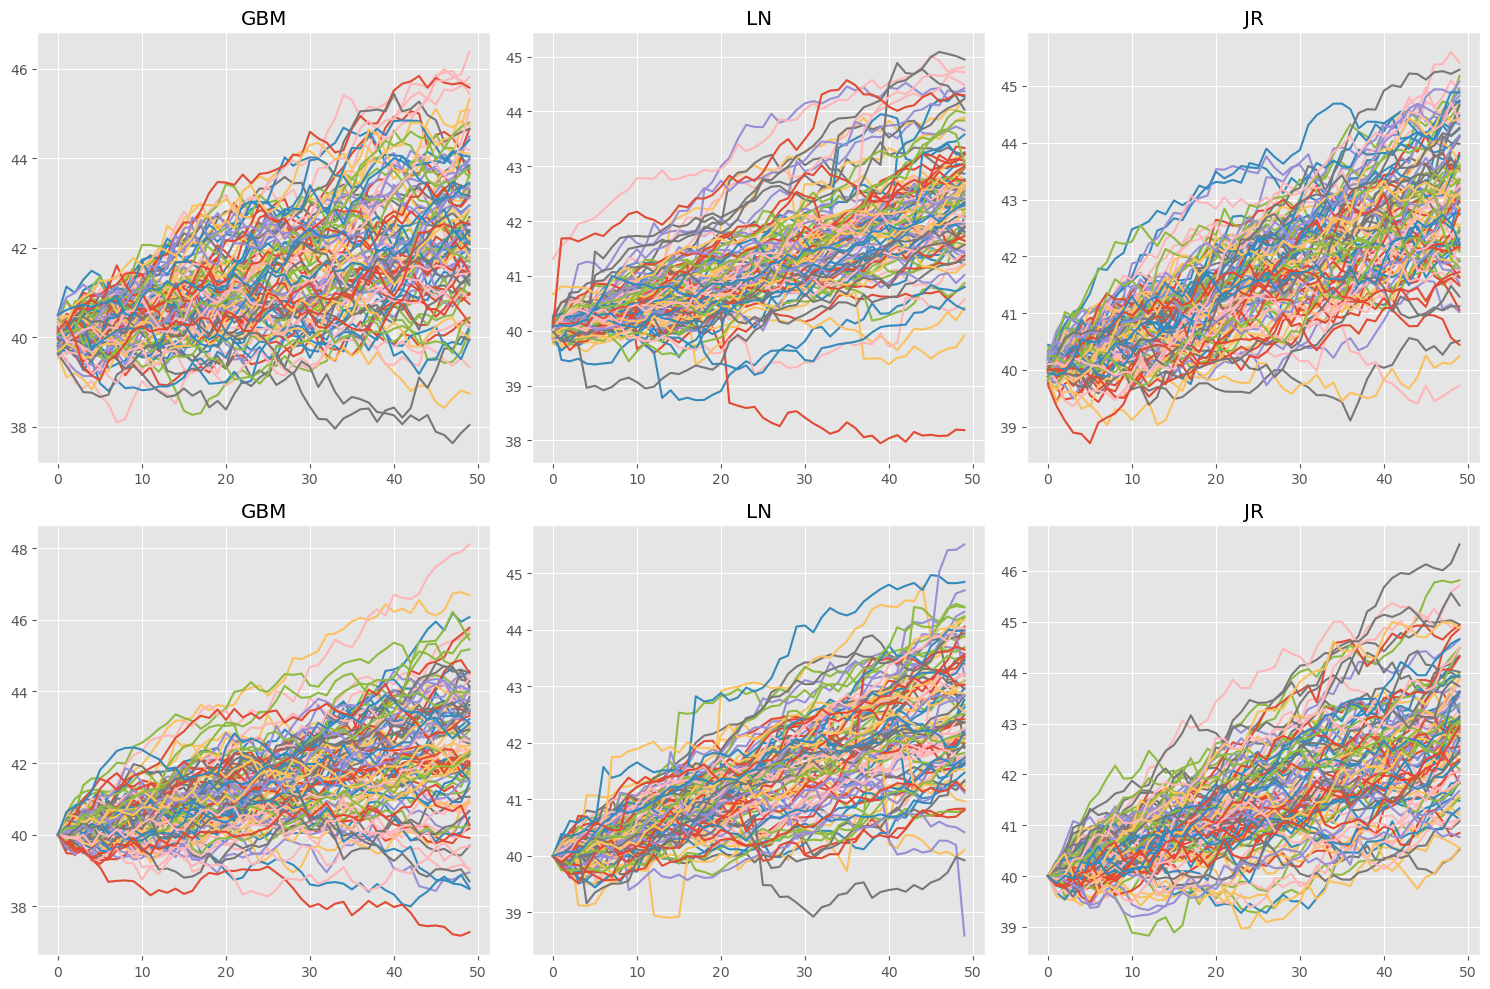

In [229]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Adjust the figsize as needed

# Plotting for the first row
axes[0, 0].plot(merton_jump_paths1(S0, 100, GBM_lam, GBM_sigma, GBM_mu, GBM_v, m, 1, I))
axes[0, 0].set_title('GBM')
axes[0, 1].plot(merton_jump_paths1(S0, 100, LN_lam, LN_sigma, LN_mu, LN_v, m, 1, I))
axes[0, 1].set_title('LN')
axes[0, 2].plot(merton_jump_to_ruin_paths1(S0, 100, JR_lam, JR_sigma, JR_mu, 0, 0, 1, I))
axes[0, 2].set_title('JR')

# Plotting for the second row
axes[1, 0].plot(merton_jump_paths(S0, 100, GBM_lam, GBM_sigma, GBM_mu, GBM_v, m, 1, I).T)
axes[1, 0].set_title('GBM')
axes[1, 1].plot(merton_jump_paths(S0, 100, LN_lam, LN_sigma, LN_mu, LN_v, m, 1, I).T)
axes[1, 1].set_title('LN')
axes[1, 2].plot(merton_jump_to_ruin_paths(S0, 100, JR_lam, JR_sigma, JR_mu, 0, 0, 1, I).T)
axes[1, 2].set_title('JR')

plt.tight_layout()  # This ensures that the subplots fit nicely in the figure area
plt.show()

# European

In [225]:
def closed_formula_GBM(S0, mu, sigma, T, K):
    """
    Black Scholes closed formula:
    """
    d1 = (np.log(S0 / K) + (mu + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-mu * T) * ss.norm.cdf(-d2) - S0 * ss.norm.cdf(-d1)

def closed_formula_GBM_call(S0, mu, sigma, T, K):
    """
    Black Scholes closed formula:
    """
    d1 = (np.log(S0 / K) + (mu + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * ss.norm.cdf(d1) - K * np.exp(-mu * T) * ss.norm.cdf(d2)

def closed_formula_LN(S0):
    m = LN_lam * (np.exp(LN_mu + (LN_sigma**2) / 2) - 1)
    lam2 = LN_lam * np.exp(LN_mu + LN_sigma**2) / 2
    v = LN_v

    tot = 0
    for k in range(3):
        tot += (np.exp(-lam2 * T) * (lam2 * T) ** k / np.math.factorial(k)) * closed_formula_GBM(
        S0,
        LN_mu - m + k * (LN_mu + 0.5 * LN_sigma**2) / T,
        np.sqrt(LN_sigma**2 + k * v**2 / T),
        T,
        K
        )
        return tot
    
def closed_formula_Call_JR(S0):
    return np.exp(-JR_lam * T) * closed_formula_GBM_call(S0, r, 0.04, T, K)

def closed_formula_Put_JR(S0):
    return closed_formula_Call_JR(S0) - S0 + K * np.exp(-r * T)

# Simulation

In [226]:
GBM_matrices = merton_jump_paths(S0, paths, GBM_lam, GBM_sigma, GBM_mu, GBM_v, m, T, I)
LN_matrices = merton_jump_paths(S0, paths, LN_lam, LN_sigma, LN_mu, LN_v, m, T, I)
JR_matrices = merton_jump_paths(S0, paths, JR_lam, JR_sigma, JR_mu, 0, m, T, I)

GBM_price, GBM_V, GBM_se = LSM(K, GBM_matrices, I, df, basis, deg)
LN_price, LN_V, LN_se = LSM(K, LN_matrices, I, df, basis, deg)
JR_price, JR_V, JR_se = LSM(K, JR_matrices, I, df, basis, deg)

GBM_mean = np.mean(GBM_matrices)
LN_mean = np.mean(LN_matrices)
JR_mean = np.mean(JR_matrices)

GBM_var = np.var(GBM_matrices)
LN_var = np.var(LN_matrices)
JR_var = np.var(JR_matrices)

In [227]:
print('GBM price: ', GBM_price)
print('LN price: ', LN_price)
print('JR price: ', JR_price)

print('GBM SE: ', GBM_se)
print('LN SE: ', LN_se)
print('JR SE: ', JR_se)

print('GBM mean: ', GBM_mean)
print('LN mean: ', LN_mean)
print('JR mean: ', JR_mean)

print('GBM var: ', GBM_var)
print('LN var: ', LN_var)
print('JR_var: ', JR_var)

GBM price:  0.13046579756937024
LN price:  0.065772018649862
JR price:  0.07176999164627774
GBM SE:  0.001577700828311552
LN SE:  0.0014864593109282993
JR SE:  0.0009713764898790128
GBM mean:  41.189907657883296
LN mean:  41.202122601243275
JR mean:  41.40460337181519
GBM var:  1.8918032264729137
LN var:  1.1959511668258702
JR_var:  1.4938555857241789


In [228]:
print(f"  European_GBM: {closed_formula_GBM(S0, GBM_mu, GBM_sigma, T, K)}")
print(f"  European_LN: {closed_formula_LN(S0)}")
print(f"  European_JR: {closed_formula_Put_JR(S0)}")

  European_GBM: 0.045498454729779425
  European_LN: 0.21293504149574494
  European_JR: 0.021867634639797018
